### 1. Import libraries and dataframes
### 2. Subset data to electric vehicles only
### 3. Create a line chart
### 4.  Decompose the data components
### 5.  Conduct a Dickey-Fuller Test
### 6.  Stationarize the data via differencing as often as needed

    1. Import libraries and dataframes

In [1]:
# Python libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Ensure graphs can be displayed
%matplotlib inline

In [3]:
#Create path shortcut
path = r'C:\Users\dodge\24-08-27 Transportation'

In [4]:
#Open most recent dataframe
df_cars = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'WA_combined.csv'), index_col = False)

     2. Subset data to electric vehicles only

In [5]:
df_cars.head()

,date,date.1,Battery_BEVs,Hybrid_(PHEVs),EV_Total,Non-Electric_Total,Total_Veh
0,2017-April,2017-April,15710,8033,23743,5903945,5927688
1,2017-August,2017-August,17191,8882,26073,5918315,5944388
2,2017-December,2017-December,18688,9828,28516,5951617,5980133
3,2017-February,2017-February,14835,7638,22473,5909019,5931492
4,2017-January,2017-January,14362,7436,21798,5919408,5941206


In [6]:
#Drop the extra date column
df_cars=df_cars.drop(columns = 'date.1')
df_cars.head()

,date,Battery_BEVs,Hybrid_(PHEVs),EV_Total,Non-Electric_Total,Total_Veh
0,2017-April,15710,8033,23743,5903945,5927688
1,2017-August,17191,8882,26073,5918315,5944388
2,2017-December,18688,9828,28516,5951617,5980133
3,2017-February,14835,7638,22473,5909019,5931492
4,2017-January,14362,7436,21798,5919408,5941206


In [7]:
data_sub = df_cars[['date', 'EV_Total']]

In [8]:
from datetime import date

data_sub['datetime'] = pd.to_datetime(data_sub['date'], format ='%Y-%B')
data_sub = data_sub.set_index('datetime').sort_index()
data_sub.drop(['date'], axis=1, inplace=True)
data_sub.head(8)

,EV_Total
datetime,
2017-01-01,21798
2017-02-01,22473
2017-03-01,23065
2017-04-01,23743
2017-05-01,24352
2017-06-01,25006
2017-07-01,25573
2017-08-01,26073


    3. Create a line chart

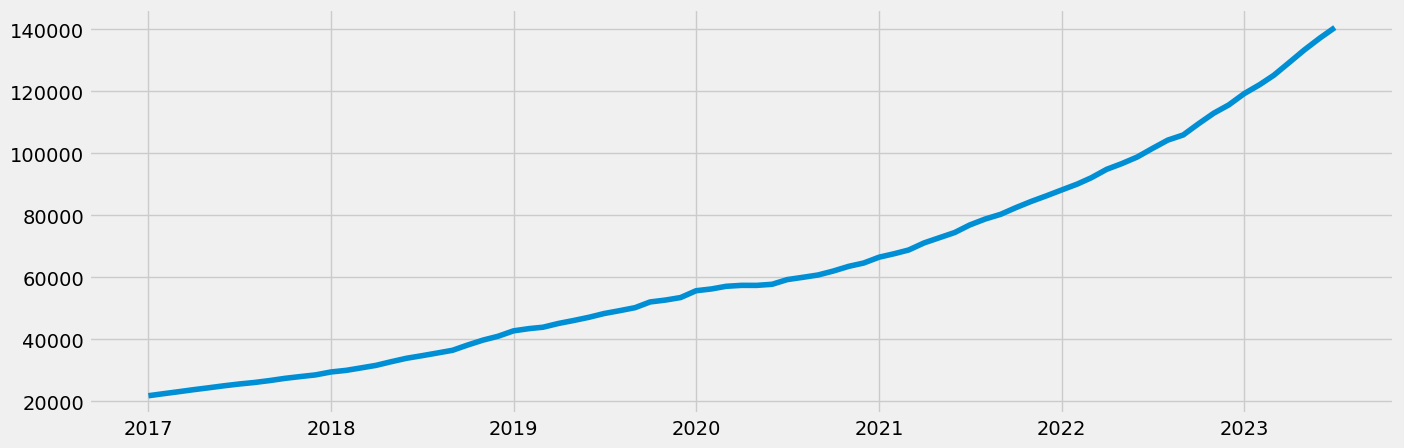

In [9]:
#Plot the electric vehicle dataset
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

#### Validate by checking for missing values and duplicates

In [10]:
#Check for missing values
data_sub.isnull().sum()

EV_Total    0
dtype: int64

In [11]:
#Check for duplicates
dups=data_sub.duplicated()
dups.sum()

0

     4.  Decompose the data components

#### Decompose time series data using additive model

In [12]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [13]:
#Import library to define fixed size for all special chart
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

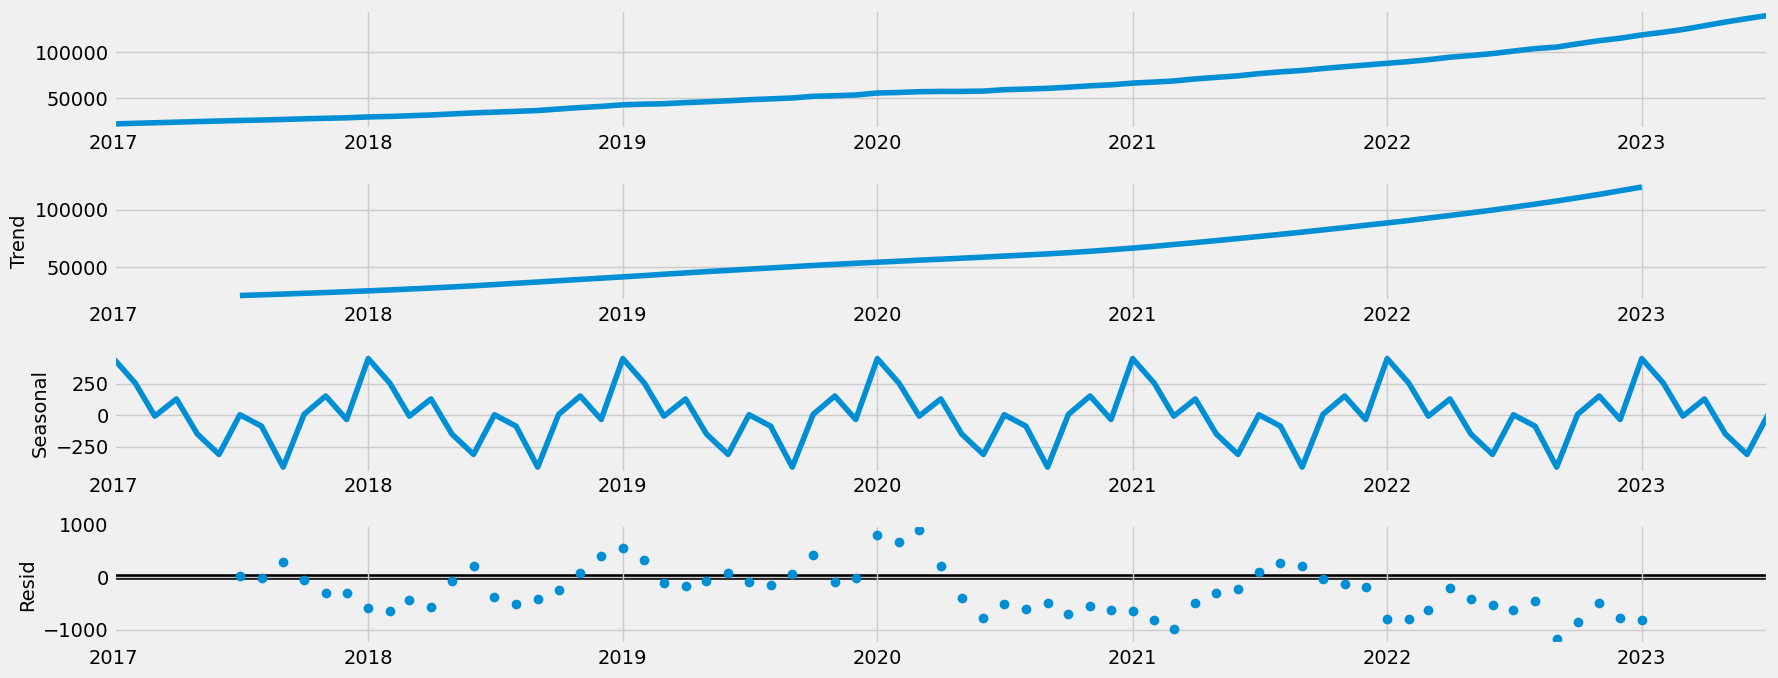

In [14]:
#Plot the  trend, seasonal, and noise

decomposition.plot()
plt.show()

The top line is my data.

Second line is the trend which follows the same pattern indicating that the data doesn't have much noise and doesn't need to be smoothed.  The trend has a gradual rise and seems to incline faster right around 2021.

The third line is seasonality.  It looks like a nice rocky mountain range with similiar peaks and valleys year over year.  It would be interesting to see what month the peaks occur in--is this after tax season when there are rebates to spend; after new car models are released; or what factors seem to drive spikes at regular occurrences.  One theory is regularity of repeat customers because vehicle registrations must be renewed on an annual basis, this could be the ebb and flow of repeat registrations.

The fourth line is residual, or noise.  There is a peak of noise right around 2020 and then a drop that generally remains below the line except for one small blip.

Conduct a Dickey-Fuller test to check for stationarity

In [18]:
#Import dickey-fuller function
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

#Define the function
def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['EV_Total'])

Dickey-Fuller Stationarity test:
Test Statistic                  2.578283
p-value                         0.999071
Number of Lags Used             3.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


The p-value we were looking for would be less than 0.05, and ours is .99 so pretty high.  I want the test statistic to be smaller than the critical value, (specifically critical value 5%), so I can reject the null hypothesis.  This means the data is non-stationary and should be run for autocorrelations.

Check for auto-correlations

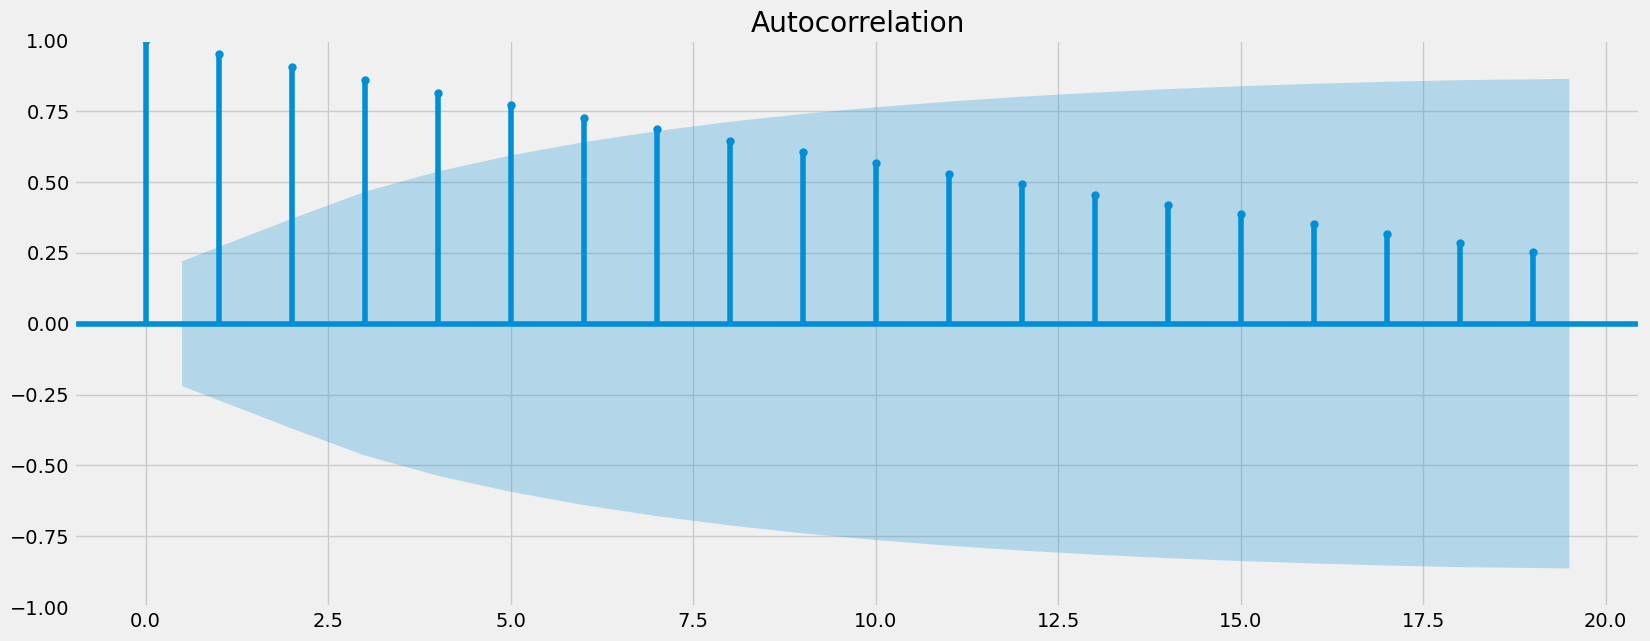

In [19]:
#Import autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub)
plt.show()

Stationarizing the EV Registrations in WA

In [20]:
# Use a formula to turn the observation to t-1, making the entire piece t - (t-1)
data_diff = data_sub - data_sub.shift(1)

In [21]:
#Remove the missing values as a result of differencing in order to re-run the dickey-fuller test
data_diff.dropna(inplace = True)

In [22]:
data_diff.head(8)

,EV_Total
datetime,
2017-02-01,675.0
2017-03-01,592.0
2017-04-01,678.0
2017-05-01,609.0
2017-06-01,654.0
2017-07-01,567.0
2017-08-01,500.0
2017-09-01,627.0


In [23]:
data_diff.columns

Index(['EV_Total'], dtype='object')

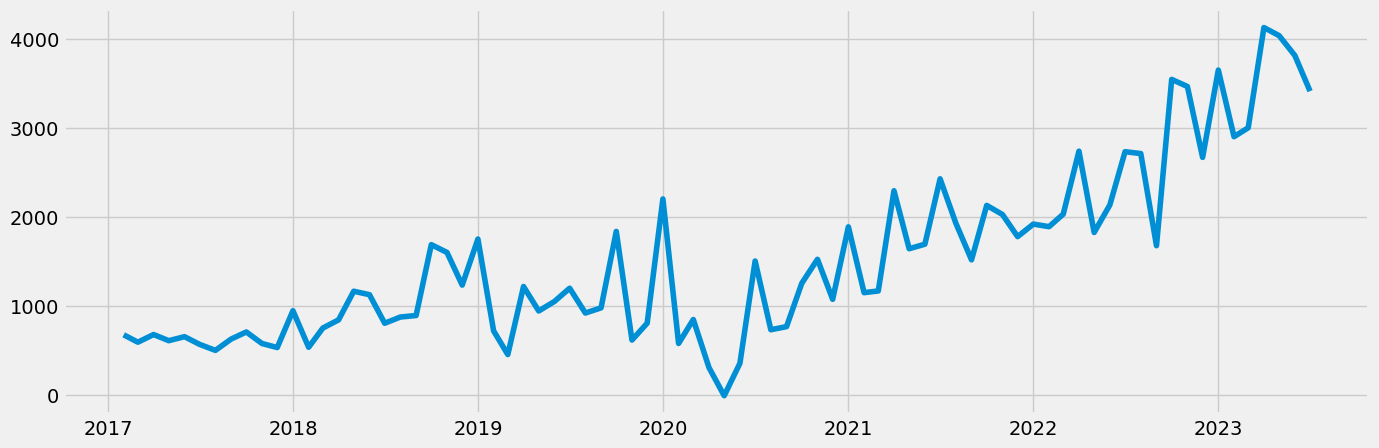

In [24]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [25]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  1.142162
p-value                         0.995561
Number of Lags Used             5.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


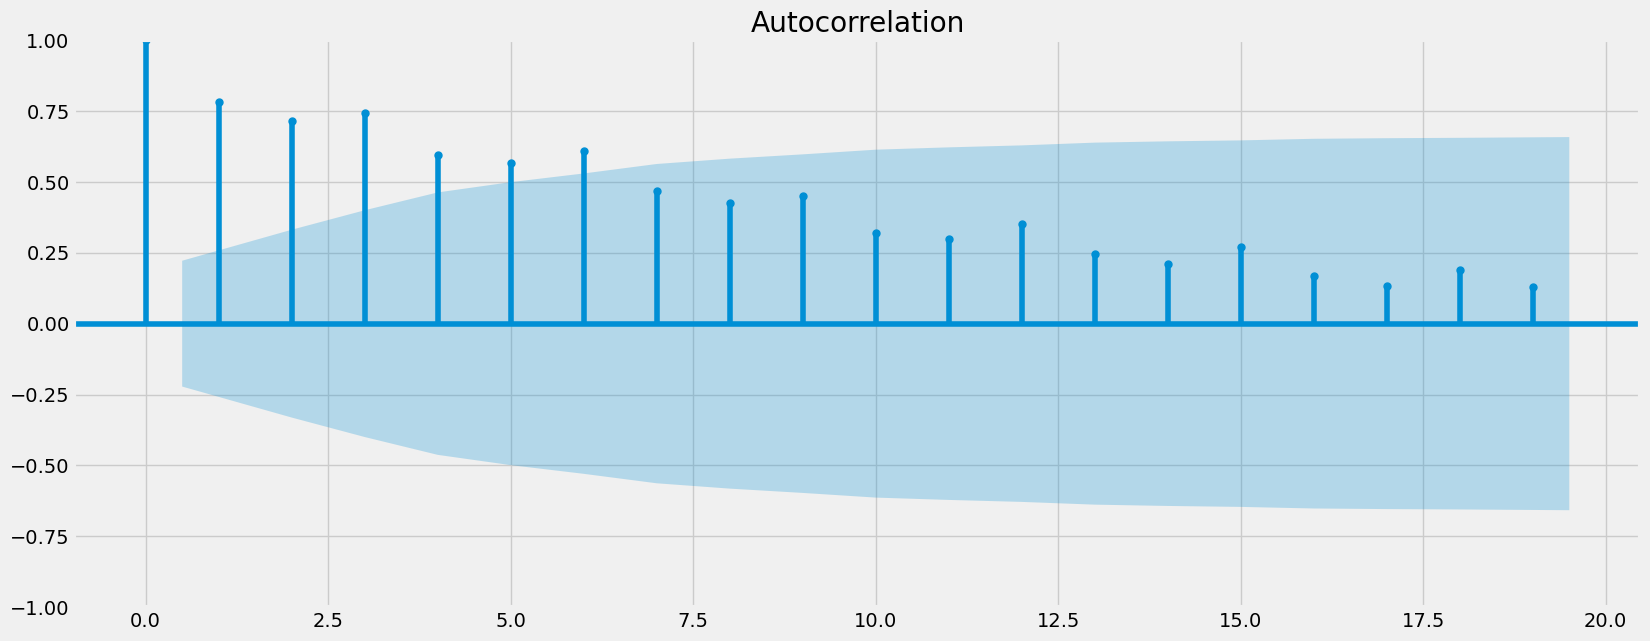

In [26]:
plot_acf(data_diff)
plt.show()

Although better, this is still not where we want it, so will repeat 

In [27]:
# Use a formula to turn the observation to t-1, making the entire piece t - (t-1)
data_diff1 = data_diff - data_diff.shift(1)

In [28]:
#Remove the missing values as a result of differencing in order to re-run the dickey-fuller test
data_diff1.dropna(inplace = True)

In [29]:
data_diff1.head(8)

,EV_Total
datetime,
2017-03-01,-83.0
2017-04-01,86.0
2017-05-01,-69.0
2017-06-01,45.0
2017-07-01,-87.0
2017-08-01,-67.0
2017-09-01,127.0
2017-10-01,80.0


In [30]:
data_diff1.columns

Index(['EV_Total'], dtype='object')

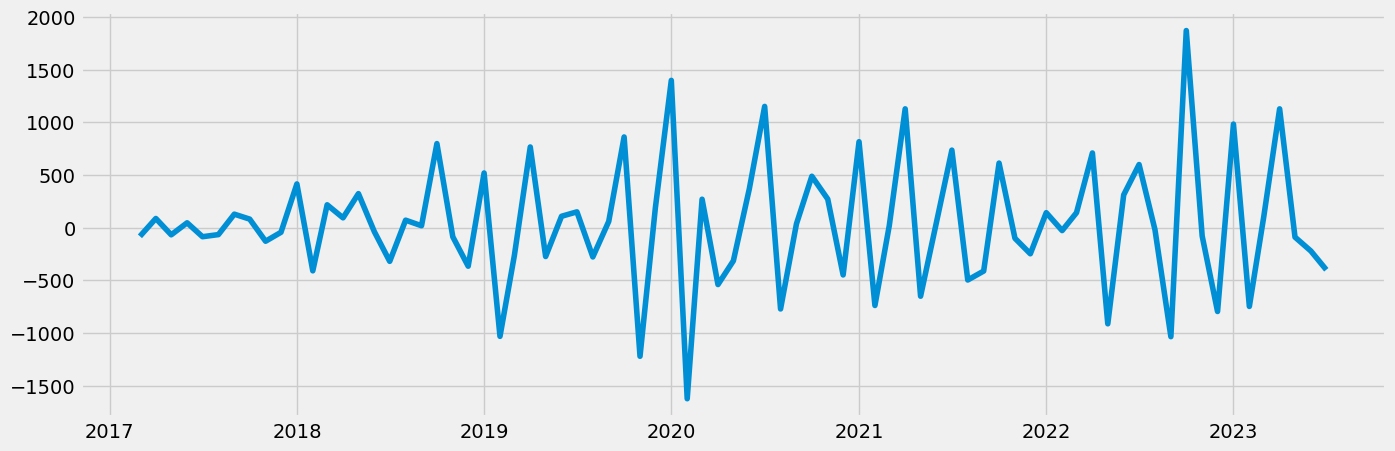

In [31]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff1)

In [32]:
dickey_fuller(data_diff1)

Dickey-Fuller Stationarity test:
Test Statistic                -1.370967e+01
p-value                        1.244554e-25
Number of Lags Used            1.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


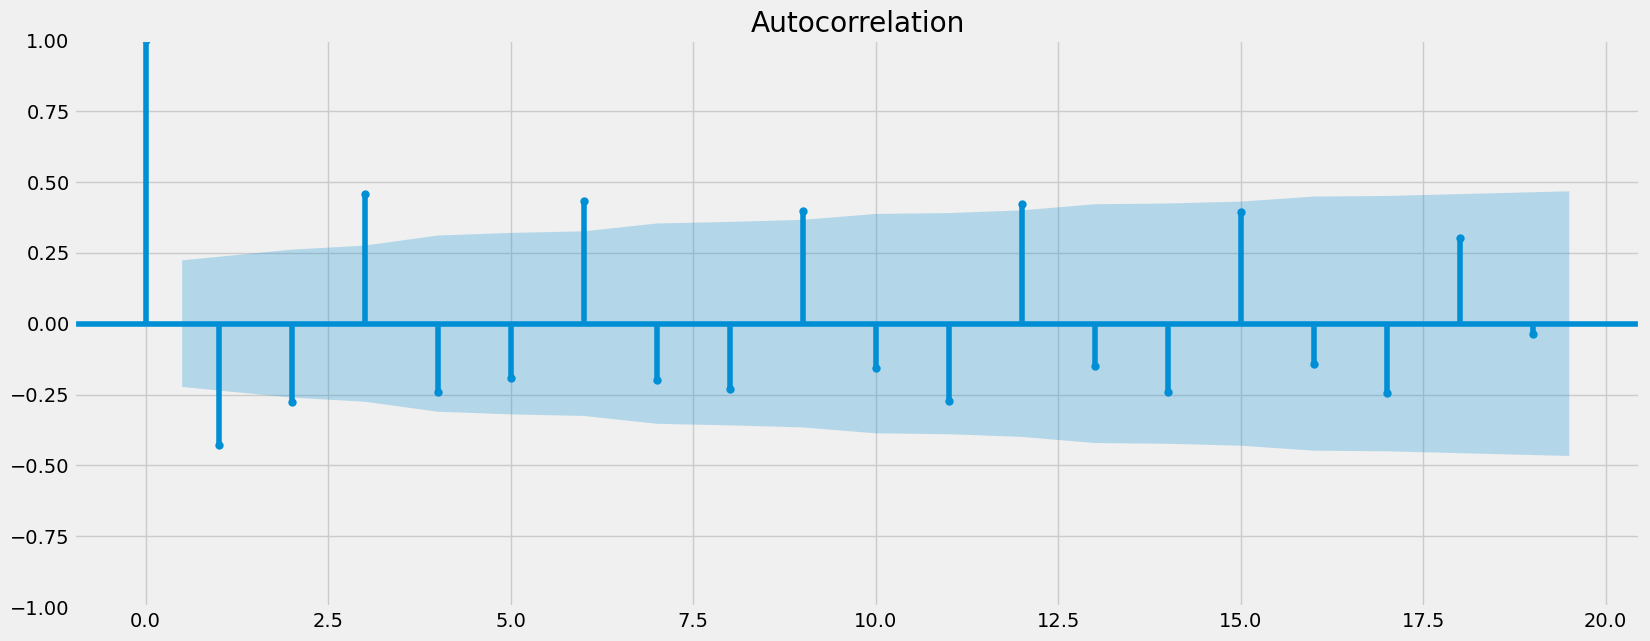

In [33]:
plot_acf(data_diff1)
plt.show()

Okay, there is a p-value less than 5% (0.05) and the test statistic is now less than the critical value (5%).  Further, there are fewer than 10 significant lags to justify another round of differencing.